In [1]:
import pandas as pd
import numpy as np 
import scipy as sp
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%precision 3

'%.3f'

In [2]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Data_병원개폐업/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Data_병원개폐업/test.csv')

In [3]:
train.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228,175.0,nursing_hospital,4.217530e+09,0.0,3.961135e+09,...,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,same
1,3,open,gyeongnam,32,19970401,410.0,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same
2,4,open,gyeonggi,89,20161228,468.0,nursing_hospital,1.004522e+09,515483669.0,4.472197e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,same
3,7,open,incheon,141,20000814,353.0,general_hospital,7.250734e+10,0.0,7.067740e+10,...,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,same
4,9,open,gyeongnam,32,20050901,196.0,general_hospital,4.904354e+10,0.0,4.765605e+10,...,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,same


In [4]:
train.shape

(301, 58)

### -목차-

#### - 탐색적 데이터 분석 및 전처리
#### - 1차 변수 선택 및 목표변수와 설명변수 간 관계 분석
#### - 로지스틱 회귀모형 적합 및 모델 평가, 해석

<hr></hr>

#### 1.탐색적 데이터 분석 및 전처리 

* 결측값 확인 및 처리

* 목표변수 범주/계급 구성 분포 확인 및 처리

* 설명변수 간 다중공선성 확인 및 처리

* 표준화, 척도 변환


In [5]:
## Data type check

print("int64 col : ",train.select_dtypes(include = ['int64']).columns)
print("object col : ",train.select_dtypes(include = ['object']).columns)
print("이 외 나머지는 전부 float64 col")

int64 col :  Index(['inst_id', 'sgg', 'openDate'], dtype='object')
object col :  Index(['OC', 'sido', 'instkind', 'ownerChange'], dtype='object')
이 외 나머지는 전부 float64 col


In [6]:
## Missing Value check

# 분석편의 위해 개/폐업별 데이터 분할
train_open = train.query("OC == 'open'")
train_close = train.query("OC == ' close'")

# 결측값을 가진 행(병원)
print("train data 중 결측값을 가진 행(병원) 수 : ",len(train.loc[train.isnull().sum(1) > 1, :]))

# open 중 결측값 가진 행(병원)
print("open 중 결측값 가진 행(병원) 수 : ", len(train_open.loc[train_open.isnull().sum(1) > 1, :]))

# close 중 결측값 가진 행(병원)
print("close 중 결측값 가진 행(병원) 수 : ", len(train_close.loc[train_close.isnull().sum(1) >1, :]))

train data 중 결측값을 가진 행(병원) 수 :  19
open 중 결측값 가진 행(병원) 수 :  14
close 중 결측값 가진 행(병원) 수 :  5


In [7]:
# close 중 재무정보 col에는 결측값이 없다.
# bedcount,ownerChange,employee 변수는 폐업 여부와 상관이 보이지 않는다.

In [8]:
## 종속변수(OC) 구성/분포 확인

print("전체 %d개의 병원 데이터 중 open :%d개, close : %d개" %(len(train),len(train_open),len(train_close)))
print("open / close의 비율이 %f 대 %f" %(len(train_open)/len(train),len(train_close)/len(train)))

# 클래스 불균형 문제 여부

전체 301개의 병원 데이터 중 open :286개, close : 15개
open / close의 비율이 0.950166 대 0.049834


In [9]:
## 설명변수 간 다중공선성 확인 및 처리
## 지속년수(*파생변수), 각 재무정보별 증감액(*파생변수), 각 재무정보별 증감율(*파생변수)

# 파생변수 생성
# 지속년수
i=0
def cal_year(x):
    global i
    i += 1
    result = 2017 - int(str(train.iloc[:,4].values[i-1])[:4])
    return result

train['지속년수'] = train['openDate'].apply(cal_year)

# 파생변수 생성
# 전년대비 증감액

index_list = []
def drop_func(train): # 재무정보 결측값 제거(open 병원에만 존재)
    global index_list
    for i in range(len(train)):
        if train.loc[i,"revenue1":"surplus2"].isnull().sum() > 0:
            index_list.append(i)
    
    result = train.drop(index_list)
    return result
train = drop_func(train)

# 중간 copy
train_result = train.copy()
# 지속년수,재무정보만 train_result에 포함
train_result = train[['OC','지속년수','revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1',
       'interest1', 'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1',
       'receivableS1', 'inventoryAsset1', 'nonCAsset1', 'tanAsset1',
       'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'surplus1',
       'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2',
       'interest2', 'ctax2', 'profit2', 'liquidAsset2', 'quickAsset2',
       'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2',
       'OnonCAsset2', 'receivableL2', 'debt2', 'liquidLiabilities2',
       'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2']]

train_result['매출액_증감액'] = train['revenue1'] - train['revenue2']
train_result['매출원가_증감액'] = train['salescost1'] - train['salescost2']
train_result['판매비관리비_증감액'] = train['sga1'] - train['sga2']
train_result['급여_증감액'] = train['salary1'] - train['salary2']
train_result['영업외수익_증감액'] = train['noi1'] - train['noi2']
train_result['영업외비용_증감액'] = train['noe1'] - train['noe2']
train_result['이자비용_증감액'] = train['interest1'] - train['interest2']
train_result['법인세비용_증감액'] = train['ctax1'] - train['ctax2']
train_result['당기순이익_증감액'] = train['profit1'] - train['profit2']
train_result['유동자산_증감액'] = train['liquidAsset1'] - train['liquidAsset2']
train_result['당좌자산_증감액'] = train['quickAsset1'] - train['quickAsset2']
train_result['미수금_증감액'] = train['receivableS1'] - train['receivableS2']
train_result['재고자산_증감액'] = train['inventoryAsset1'] - train['inventoryAsset2']
train_result['비유동자산_증감액'] = train['nonCAsset1'] - train['nonCAsset2']
train_result['유형자산_증감액'] = train['tanAsset1'] - train['tanAsset2']
train_result['기타비유동자산_증감액'] = train['OnonCAsset1'] - train['OnonCAsset2']
train_result['장기미수금_증감액'] = train['receivableL1'] - train['receivableL2']
train_result['부채총계_증감액'] = train['debt1'] - train['debt2']
train_result['유동부채_증감액'] = train['liquidLiabilities1'] - train['liquidLiabilities2']
train_result['단기차입금_증감액'] = train['shortLoan1'] - train['shortLoan2']
train_result['비유동부채_증감액'] = train['NCLiabilities1'] - train['NCLiabilities2']
train_result['장기차입금_증감액'] = train['longLoan1'] - train['longLoan2']
train_result['순자산총계_증감액'] = train['netAsset1'] - train['netAsset2']
train_result['이익잉여금_증감액'] = train['surplus1'] - train['surplus2']


# ## 파생변수 생성
# ## 증감율
# train_result['매출액_증감율'] = (train['revenue1'] - train['revenue2'])/train['revenue2'] * 100
# train_result['매출원가_증감율'] = (train['salescost1'] - train['salescost2'])/train['salescost2'] * 100
# train_result['판매비관리비_증감율'] = (train['sga1'] - train['sga2'])/train['sga2'] * 100
# train_result['급여_증감율'] = (train['salary1'] - train['salary2'])/train['salary2'] * 100
# train_result['영업외수익_증감율'] = (train['noi1'] - train['noi2'])/train['noi2'] * 100
# train_result['영업외비용_증감율'] = (train['noe1'] - train['noe2'])/train['noe2'] * 100
# train_result['이자비용_증감율'] = (train['interest1'] - train['interest2'])/train['interest2'] * 100
# train_result['법인세비용_증감율'] = (train['ctax1'] - train['ctax2'])/train['ctax2'] * 100
# train_result['당기순이익_증감율'] = (train['profit1'] - train['profit2'])/train['profit2'] * 100
# train_result['유동자산_증감율'] = (train['liquidAsset1'] - train['liquidAsset2'])/train['liquidAsset2'] * 100
# train_result['당좌자산_증감율'] = (train['quickAsset1'] - train['quickAsset2'])/train['quickAsset2'] * 100
# train_result['미수금_증감율'] = (train['receivableS1'] - train['receivableS2'])/train['receivableS2'] * 100
# train_result['재고자산_증감율'] = (train['inventoryAsset1'] - train['inventoryAsset2'])/train['inventoryAsset2'] * 100
# train_result['비유동자산_증감율'] = (train['nonCAsset1'] - train['nonCAsset2'])/train['nonCAsset2'] * 100
# train_result['유형자산_증감율'] = (train['tanAsset1'] - train['tanAsset2'])/train['tanAsset2'] * 100
# train_result['기타비유동자산_증감율'] = (train['OnonCAsset1'] - train['OnonCAsset2'])/train['OnonCAsset2'] * 100
# train_result['장기미수금_증감율'] = (train['receivableL1'] - train['receivableL2'])/train['receivableL2'] * 100
# train_result['부채총계_증감율'] = (train['debt1'] - train['debt2'])/train['debt2'] * 100
# train_result['유동부채_증감율'] = (train['liquidLiabilities1'] - train['liquidLiabilities2'])/train['liquidLiabilities2'] * 100
# train_result['단기차입금_증감율'] = (train['shortLoan1'] - train['shortLoan2'])/train['shortLoan2'] * 100
# train_result['비유동부채_증감율'] = (train['NCLiabilities1'] - train['NCLiabilities2'])/train['NCLiabilities2'] * 100
# train_result['장기차입금_증감율'] = (train['longLoan1'] - train['longLoan2'])/train['longLoan2'] * 100
# train_result['순자산총계_증감율'] = (train['netAsset1'] - train['netAsset2'])/train['netAsset2'] * 100
# train_result['이익잉여금_증감율'] = (train['surplus1'] - train['surplus2'])/train['surplus2'] * 100

train_result = train_result[['OC','지속년수','매출액_증감액', '매출원가_증감액',
       '판매비관리비_증감액', '급여_증감액', '영업외수익_증감액', '영업외비용_증감액', '이자비용_증감액',
       '법인세비용_증감액', '당기순이익_증감액', '유동자산_증감액', '당좌자산_증감액', '미수금_증감액', '재고자산_증감액',
       '비유동자산_증감액', '유형자산_증감액', '기타비유동자산_증감액', '장기미수금_증감액', '부채총계_증감액',
       '유동부채_증감액', '단기차입금_증감액', '비유동부채_증감액', '장기차입금_증감액', '순자산총계_증감액',
       '이익잉여금_증감액']]

# OC => 0,1
def func_OC(x):
    if x == 'open':
        return 1
    else :
        return 0
train_result['OC'] = train_result['OC'].apply(func_OC)

In [11]:
## logistic modeling
model_1 = smf.glm(
    formula = "OC ~ 지속년수 + 매출액_증감액 + 매출원가_증감액 + \
       영업외수익_증감액 + 영업외비용_증감액 + 이자비용_증감액 + 법인세비용_증감액 + 당기순이익_증감액 + \
       유동자산_증감액 + 미수금_증감액 + 재고자산_증감액 + 비유동자산_증감액 + \
       기타비유동자산_증감액 + 장기미수금_증감액 + 부채총계_증감액 + 유동부채_증감액 + 단기차입금_증감액 + \
       + 장기차입금_증감액 + 이익잉여금_증감액",
    data=train_result,
    family = sm.families.Binomial()
).fit()

In [12]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     OC   No. Observations:                  293
Model:                            GLM   Df Residuals:                      273
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -44.745
Date:                Sun, 19 Jan 2020   Deviance:                       89.490
Time:                        16:35:09   Pearson chi2:                     391.
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.9176      0.591      4.933      0.000       1.758       4.077
지속년수            0.0351      0.043      0.817      0.414      -0.049       0.119
매출액_증감액      8.004e-10   3.94e-10      2.032      0.042    2.84e-11    1.57e-09
매출원가_증감액    -1.279e-09   5.11e-10     -2.501      0.012   -2.28e-09   -2.77e-10
영업외수익_증감액    1.737e-09   1.52e-09      1.144      0.253   -1.24e-09    4.71e-09
영업외비용_증감액   -6.214e-10   1.02e-09     -0.611      0.541   -2.61e-09    1.37e-09
이자비용_증감액     5.593e-11   6.09e-09      0.009      0.993   -1.19e-08     1.2e-08
법인세비용_증감액   -1.657e-09   3.34e-09     -0.495      0.620   -8.21e-09     4.9e-09
당기순이익_증감액   -1.642e-09   7.07e-10     -2.323      0.020   -3.03e-09   -2.57e-10
유동자산_증감액     1.335e-10   5.28e-10      0.253      0.800      -9e-10    1.17e-09
미수금_증감액     -1.169e-09   9.44e-10     -1.238      0.216   -3.02e-09    6.81e-10
재고자산_증감액    -1.115e-08   6.73e-09     -1.656      0.098   -2.43e-08    2.04e-09
비유동자산_증감액    3.028e-11   2.47e-10      0.123      0.902   -4.54e-10    5.14e-10
기타비유동자산_증감액 -9.094e-10    9.5e-10     -0.957      0.338   -2.77e-09    9.52e-10
장기미수금_증감액   -2.504e-06      0.002     -0.001      0.999      -0.004       0.004
부채총계_증감액     3.481e-10   3.14e-10      1.107      0.268   -2.68e-10    9.64e-10
유동부채_증감액    -8.182e-10   5.16e-10     -1.587      0.112   -1.83e-09    1.92e-10
단기차입금_증감액    6.955e-10   4.18e-10      1.665      0.096   -1.23e-10    1.51e-09
장기차입금_증감액   -6.921e-10    4.9e-10     -1.411      0.158   -1.65e-09    2.69e-10
이익잉여금_증감액   -6.776e-11   2.46e-10     -0.276      0.783   -5.49e-10    4.14e-10
===============================================================================
"""

In [13]:
# AIC
model_1.aic.round(3)

129.49

In [15]:
## 변수선택 후 modeling
model_2 = smf.glm(
    formula = "OC~ 매출액_증감액+매출원가_증감액+당기순이익_증감액",
    data=train_result,
    family = sm.families.Binomial()
).fit()

In [16]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     OC   No. Observations:                  293
Model:                            GLM   Df Residuals:                      289
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -55.510
Date:                Sun, 19 Jan 2020   Deviance:                       111.02
Time:                        16:38:30   Pearson chi2:                     402.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9159      0.295      9.889      0.000       2.338       3.494
매출액_증감액     2.781e-10   2.15e-10      1.296      0.195   -1.43e-10    6.99e-10
매출원가_증감액   -5.828e-10   3.16e-10     -1.845      0.065    -1.2e-09    3.62e-11
당기순이익_증감액  -7.859e-10    3.2e-10     -2.454      0.014   -1.41e-09   -1.58e-10
==============================================================================
"""

In [18]:
model_2.aic.round(3)

119.02

독립변수의 최적개수 : 2
최적 독립변수 : ['유동자산_증감액', '비유동자산_증감액']


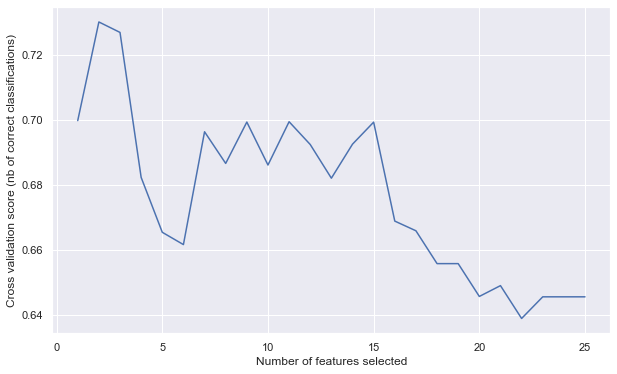

In [24]:
# 재귀적 특성제거를 통한 변수선택
# search optimal parameter

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression


X = train_result.loc[:,"지속년수":]
y = train_result['OC']

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("독립변수의 최적개수 : %d" % rfecv.n_features_)
print('최적 독립변수 : %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [25]:
# RFE 선택법에 따른 모델링
model_3 = smf.glm(
    formula = "OC~ 유동자산_증감액 + 비유동자산_증감액",
    data=train_result,
    family = sm.families.Binomial()
).fit()

In [26]:
model_3.aic.round(3)

122.348